# Multilayer Perceptron on Traffic Dataset

In [89]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Module, Linear, ReLU, Softmax, CrossEntropyLoss
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torchinfo import summary
from torch.optim import SGD, Adam

from IPython.display import display

from livelossplot import PlotLosses

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

device = torch.device("cpu")

traffic_train = pd.read_csv("../../datasets/training_data.csv", keep_default_na=False, encoding='latin1')
traffic_test = pd.read_csv("../../datasets/test_data.csv", keep_default_na=False, encoding='latin1')

## Data Preparation

In [90]:
# Data preprocessing
for df in [traffic_train, traffic_test]:
    df['record_date'] = pd.to_datetime(df['record_date'])
    df['hour'] = df['record_date'].dt.hour
    df['day_of_week'] = df['record_date'].dt.dayofweek
    df['month'] = df['record_date'].dt.month
    df.drop(columns=['record_date'], inplace=True)

speed_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
traffic_train['AVERAGE_SPEED_DIFF'] = traffic_train['AVERAGE_SPEED_DIFF'].map(speed_map).astype(int)

luminosity_map = {'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2}
traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)

/tmp/ipykernel_4844/359797340.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)


## Data Split

In [91]:
class CSVDataset():
    def __init__(self):
        df_X = traffic_train.drop(columns=['AVERAGE_SPEED_DIFF','city_name','AVERAGE_PRECIPITATION','AVERAGE_RAIN','AVERAGE_CLOUDINESS'])
        df_y = traffic_train['AVERAGE_SPEED_DIFF']

        self.X = df_X.values
        self.y = df_y.values

        self.X = self.X.astype('float32')
        self.y = torch.tensor(self.y, dtype=torch.long, device=device)
        
        print(self.X.shape)
        print(self.y.shape)
        print(self.X.ndim)
        print(self.y.ndim)
        print(self.X.dtype)
        print(self.y.dtype)
        
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    def get_splits(self, n_test, n_val):
        test_size = round(n_test * len(self.X))
        val_size = round(n_val * len(self.X))
        train_size = len(self.X) - (test_size + val_size)
        return random_split(self, [train_size, test_size, val_size])
    
def prepare_data(n_test, n_val):
    dataset = CSVDataset()
    train, test, val = dataset.get_splits(n_test, n_val)
    train_dl = DataLoader(train, batch_size=len(train), shuffle=True)
    test_dl = DataLoader(test, batch_size=len(test), shuffle=True)
    val_dl = DataLoader(val, batch_size=len(val), shuffle=True)
    return train_dl, test_dl, val_dl


train_dl, test_dl, val_dl= prepare_data(0.1, 0.2)




(6812, 11)
torch.Size([6812])
2
1
float32
torch.int64


In [92]:
# Visualize a batch of data

def visualize_dataset(train_dl=train_dl, test_dl=test_dl, val_dl=val_dl):
    print(f"Train size:{len(train_dl.dataset)}") 
    print(f"Test size:{len(test_dl.dataset)}")
    print(f"Validation size:{len(val_dl.dataset)}")
    x, y = next(iter(train_dl)) 
    print(f"Shape tensor train data batch - input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor test data batch - input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))  
    print(f"Shape tensor validation data batch - input: {x.shape}, output: {y.shape}")

visualize_dataset(train_dl, test_dl, val_dl)

Train size:4769
Test size:681
Validation size:1362
Shape tensor train data batch - input: torch.Size([4769, 11]), output: torch.Size([4769])
Shape tensor test data batch - input: torch.Size([681, 11]), output: torch.Size([681])
Shape tensor validation data batch - input: torch.Size([1362, 11]), output: torch.Size([1362])


train data:  4769
None:  1551
Low:  990
Medium:  1142
High:  746
Very_High:  340
Values' mean (train):  1.440972950304047
test data:  681
None:  228
Low:  145
Medium:  169
High:  96
Very_High:  43
Values' mean (test):  1.3847283406754773
val data:  1362
None:  421
Low:  284
Medium:  340
High:  221
Very_High:  96
Values' mean (val):  1.4765051395007343


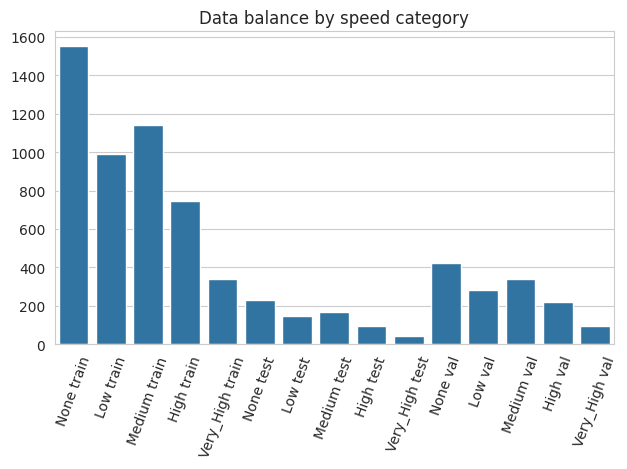

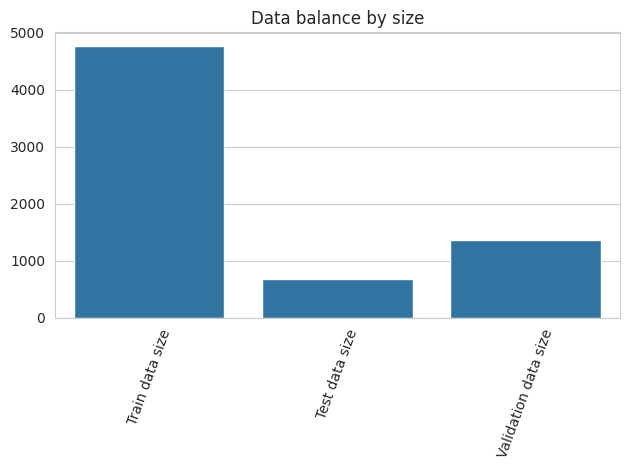

In [93]:
def visualize_holdout_balance(train_dl, test_dl, val_dl):
    _, y_train = next(iter(train_dl))                            
    _, y_test = next(iter(test_dl))
    _, y_val = next(iter(val_dl))
    
    sns.set_style('whitegrid')
    train_df = len(y_train) 
    test_df = len(y_test)
    val_df = len(y_val)

    None_train = np.count_nonzero(y_train == 0)
    Low_train = np.count_nonzero(y_train == 1)
    Medium_train = np.count_nonzero(y_train == 2)
    High_train = np.count_nonzero(y_train == 3)
    Very_High_train = np.count_nonzero(y_train == 4)
    print("train data: ", train_df)
    print("None: ", None_train) 
    print("Low: ", Low_train)
    print("Medium: ", Medium_train)
    print("High: ", High_train)
    print("Very_High: ", Very_High_train)
    print("Values' mean (train): ", np.mean(y_train.numpy()))   

    None_test = np.count_nonzero(y_test == 0)
    Low_test = np.count_nonzero(y_test == 1)
    Medium_test = np.count_nonzero(y_test == 2)
    High_test = np.count_nonzero(y_test == 3)
    Very_High_test = np.count_nonzero(y_test == 4)
    print("test data: ", test_df)
    print("None: ", None_test) 
    print("Low: ", Low_test)
    print("Medium: ", Medium_test)
    print("High: ", High_test)
    print("Very_High: ", Very_High_test)
    print("Values' mean (test): ", np.mean(y_test.numpy()))

    None_val = np.count_nonzero(y_val == 0)
    Low_val = np.count_nonzero(y_val == 1)
    Medium_val = np.count_nonzero(y_val == 2)
    High_val = np.count_nonzero(y_val == 3)
    Very_High_val = np.count_nonzero(y_val == 4)
    print("val data: ", val_df)
    print("None: ", None_val) 
    print("Low: ", Low_val)
    print("Medium: ", Medium_val)
    print("High: ", High_val)
    print("Very_High: ", Very_High_val)
    print("Values' mean (val): ", np.mean(y_val.numpy()))

    graph = sns.barplot(x=['None train', 'Low train', 'Medium train', 'High train', 'Very_High train',
                           'None test', 'Low test', 'Medium test', 'High test', 'Very_High test',
                           'None val', 'Low val', 'Medium val', 'High val', 'Very_High val'], 
                        y=[None_train, Low_train, Medium_train, High_train, Very_High_train,
                           None_test, Low_test, Medium_test, High_test, Very_High_test,
                           None_val, Low_val, Medium_val, High_val, Very_High_val])
    graph.set_title('Data balance by speed category')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()


    graph = sns.barplot(x=['Train data size','Test data size', 'Validation data size'], 
                        y=[train_df, test_df, val_df])
    graph.set_title('Data balance by size')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

visualize_holdout_balance(train_dl, test_dl, val_dl)


## model1
- feedforward network with fully interconnected layers
- **epochs**: 200
- **learning rate**: 0.001
- **layers**: 3 Linear
- **activation fuctions**: ReLU and Softmax
- **loss**: CrossEntropyLoss
- **optimiser**: SGD

In [94]:
EPOCHS = 200
LEARNING_RATE = 0.001

class MLP_1(Module):
    def __init__(self, n_inputs):
        super(MLP_1, self).__init__()
        self.hidden1 = Linear(n_inputs, 24)
        self.hidden2 = Linear(24, 12)
        self.hidden3 = Linear(12, 5)
        self.act1 = ReLU()
        self.act2 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act1(X)
        X = self.hidden3(X)
        X = self.act2(X)
        return X
    
#model = MLP_1(11)

## model2
- feedforward network with fully interconnected layers
- **epochs**: 200
- **learning rate**: 0.001
- **layers**: 3 Linear
- **activation fuctions**: ReLU and Softmax
- **loss**: CrossEntropyLoss
- **optimiser**: ADAM

In [95]:
EPOCHS = 200
LEARNING_RATE = 0.001

class MLP_2(Module):
    def __init__(self, n_inputs):
        super(MLP_2, self).__init__()
        self.hidden1 = Linear(n_inputs, 24)
        self.hidden2 = Linear(24, 12)
        self.hidden3 = Linear(12, 5)
        self.act1 = ReLU()
        self.act2 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act1(X)
        X = self.hidden3(X)
        X = self.act2(X)
        return X
    
model = MLP_2(11)

## model3
- feedforward network with fully interconnected layers
- **epochs**: 200
- **learning rate**: 0.001
- **layers**: 3 Linear
- **inicialization**: kaiming_xavier
- **activation fuctions**: ReLU and Softmax
- **loss**: CrossEntropyLoss
- **optimiser**: SGD#model 2

In [96]:
EPOCHS = 200
LEARNING_RATE = 0.001

class MLP_3(Module):
    def __init__(self, n_inputs):
        super(MLP_3, self).__init__()
        self.hidden1 = Linear(n_inputs, 24)
        self.hidden2 = Linear(24, 12)
        self.hidden3 = Linear(12, 5)

        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')  

        self.act1 = ReLU()
        self.act2 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act1(X)
        X = self.hidden3(X)
        X = self.act2(X)
        return X
    
# model = MLP_3(11)

In [97]:
print(summary(model, input_size=(len(train_dl.dataset), 11), verbose=0))
model.to(device)

def train_model(train_dl, test_dl, val_dl):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

    for epoch in range(EPOCHS):
        logs = {} 
        model.train()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()

        model.eval()
        running_loss_val  = 0.0
        running_corrects_val  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss_val = criterion(outputs, labels)
            running_loss_val += loss_val.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects_val += torch.sum(preds == labels.data)
        
        epoch_loss_val = running_loss_val / len(val_dl.dataset)
        epoch_acc_val = running_corrects_val.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss_val.item()
        logs['val_accuracy'] = epoch_acc_val.item()    
        liveloss.update(logs)
        liveloss.send()

Layer (type:depth-idx)                   Output Shape              Param #
MLP_2                                    [4769, 5]                 --
├─Linear: 1-1                            [4769, 24]                288
├─ReLU: 1-2                              [4769, 24]                --
├─Linear: 1-3                            [4769, 12]                300
├─ReLU: 1-4                              [4769, 12]                --
├─Linear: 1-5                            [4769, 5]                 65
├─Softmax: 1-6                           [4769, 5]                 --
Total params: 653
Trainable params: 653
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.11
Input size (MB): 0.21
Forward/backward pass size (MB): 1.56
Params size (MB): 0.00
Estimated Total Size (MB): 1.78


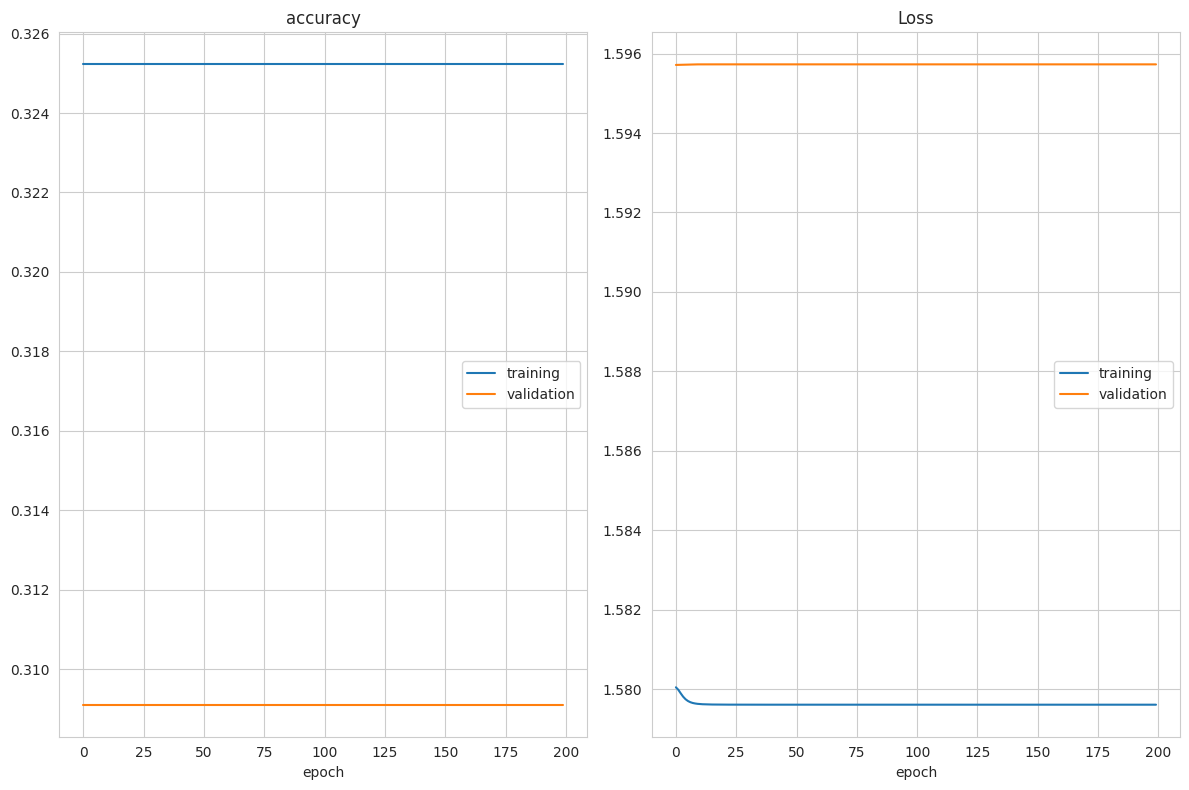

accuracy
	training         	 (min:    0.325, max:    0.325, cur:    0.325)
	validation       	 (min:    0.309, max:    0.309, cur:    0.309)
Loss
	training         	 (min:    1.580, max:    1.580, cur:    1.580)
	validation       	 (min:    1.596, max:    1.596, cur:    1.596)


In [98]:
train_model(train_dl, test_dl, val_dl)

## Evaluate Model


real:[2] prediction:[1]
real:[1] prediction:[1]
real:[3] prediction:[1]
real:[3] prediction:[1]
real:[3] prediction:[1]
real:[3] prediction:[1]
real:[1] prediction:[1]
real:[1] prediction:[1]
real:[4] prediction:[1]
real:[4] prediction:[1]
real:[2] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[3] prediction:[1]
real:[1] prediction:[1]
real:[1] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[1] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[4] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[3] prediction:[1]
real:[4] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[3] prediction:[1]
real:[1] prediction:[1]
real:[1] prediction:[1]
real:[4] prediction:[1]
real:[1] prediction:[1]
real:[4] prediction:[1]
real:[2] prediction:[1]
real:[1] prediction:[1]
real:[5] prediction:[1]
real:[4] prediction:[1]
real:[3] prediction:[1]
real:[4] predict

/home/zeee/home/uni/daa-nt/daa-tp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeee/home/uni/daa-nt/daa-tp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeee/home/uni/daa-nt/daa-tp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

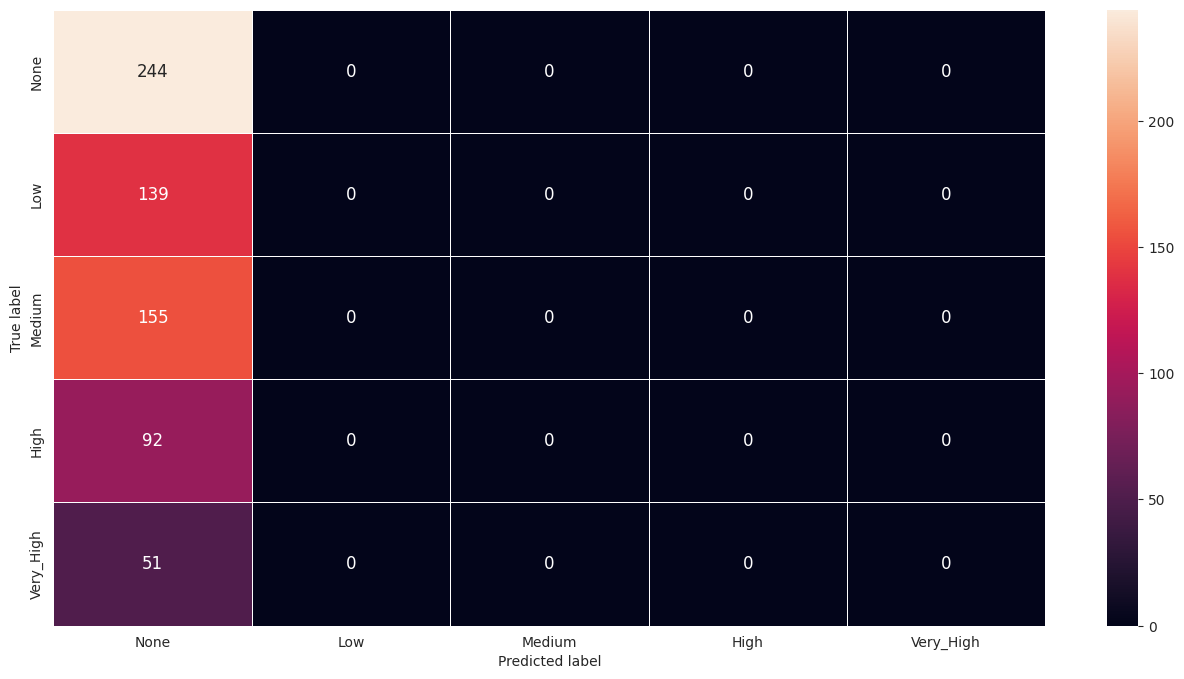

In [69]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values

def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm, annot=True, xticklabels=['None', 'Low', 'Medium', 'High', 'Very_High'],
                yticklabels=['None', 'Low', 'Medium', 'High', 'Very_High'], 
                annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predictions, actual_values = evaluate_model(test_dl, model)

success = 0
failure = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r+1} prediction:{p+1}') 
    if r==p: success+=1  
    else: failure+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'success:{success} failure:{failure}')

print(classification_report(actual_values, predictions))
cm = confusion_matrix(actual_values, predictions)
print()
display_confusion_matrix(cm)